2020/5/8
* changed auugmentations to kuzushiji augumentaitons.
* heatmaps points are smaller.
* Larger weights on regression targets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image

from nms import nms

import torch
import torchvision
from config.base import load_config

In [3]:
config = load_config("config/3x3_fullsize.yaml")

In [4]:
input_size = config.data["input_size"]
train_size = config.data["train_size"]
MODEL_SCALE = config.data["model_scale"]
FPN = config.model["fpn"]
model_name = config.model["backbone"]
try:
    bifpn = config.model["bifpn"]
except:
    bifpn = False
batch_size = config.train["batch_size"]
num_worker = config["num_workers"]
device = config["device"]
lr = config.optimizer.params["encoder_lr"]
WARMUP = True
WARMUPEND = 1

TRAIN = True
CONTINUE = False
if CONTINUE:
    lr = 1e-5
    modelpath = None

loadepoch = 24

IN_SCALE = input_size/train_size

###############
watermark = config["watermark"]
watermark

'rx101_FPN_fullsize_3x3'

## Prepare labels

In [5]:
from dataset import split
train_id, val_id, train_df, val_df = split.make_dfsplits(config)

## compile data processing

In [6]:
# Get augumentations
from aug import get_train_aug, get_val_aug
train_aug = get_train_aug(config)
val_aug = get_val_aug(config)

In [7]:
# import datasets
from dataset.dataset import WheatDataset
traindataset = WheatDataset(config, train_id, train_df, train_aug, train=True)
valdataset = WheatDataset(config, val_id, val_df, val_aug)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


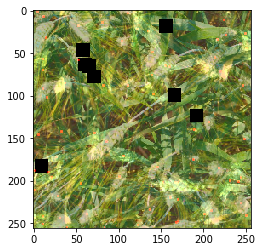

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


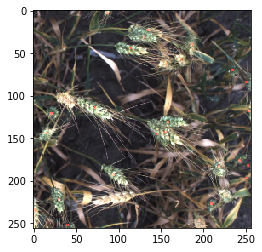

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


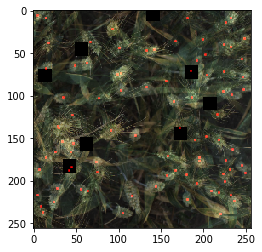

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


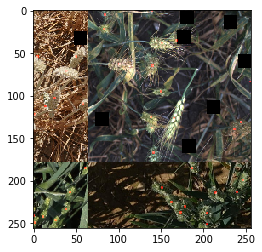

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


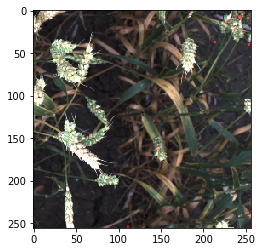

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


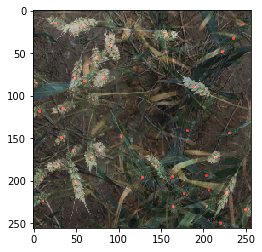

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


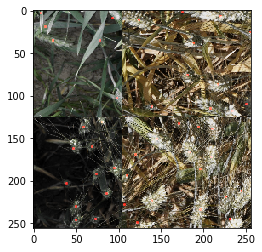

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


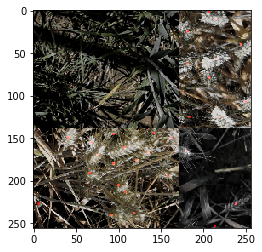

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


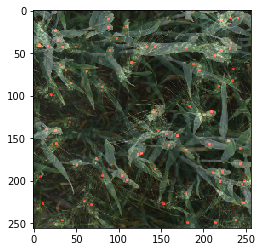

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


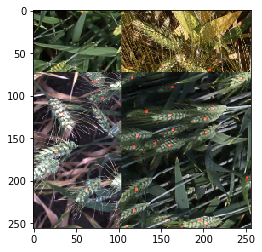

In [8]:
# Test dataset
for i in range(10):
    img, hm, regr = traindataset[i]
    hm = hm.numpy()
    regr = regr.numpy()
    img = img.permute(1,2,0).cpu().numpy()
    hm = np.array([hm, np.zeros_like(hm), np.zeros_like(hm)])
    plt.imshow(img[::4,::4,:] + hm.transpose([1,2,0]))
    plt.show()

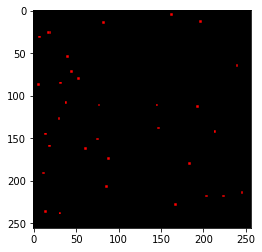

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


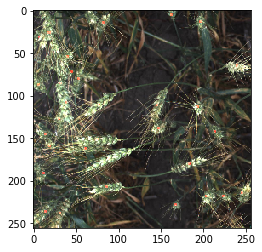

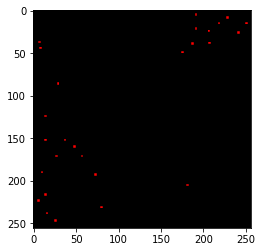

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


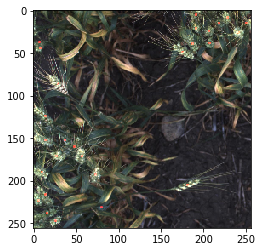

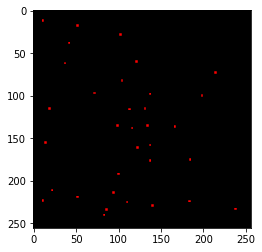

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


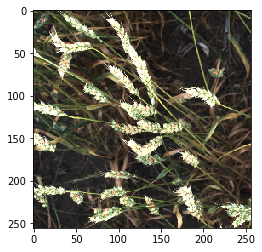

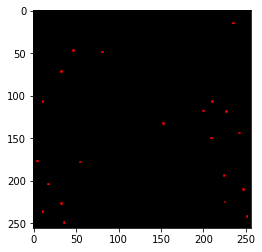

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


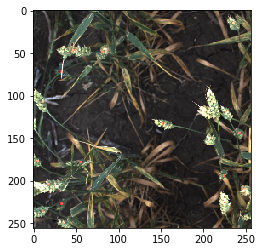

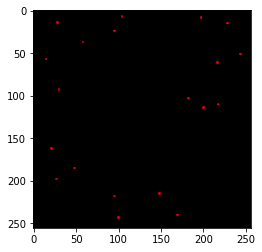

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


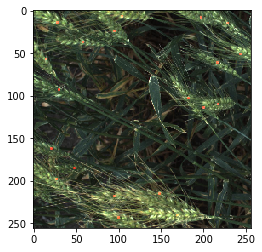

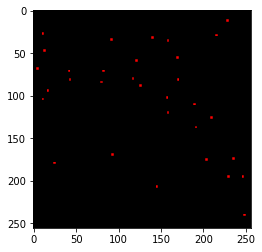

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


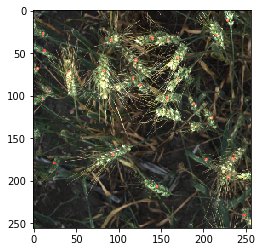

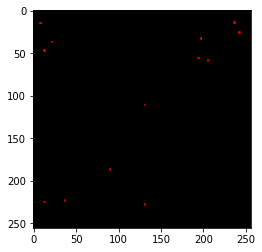

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


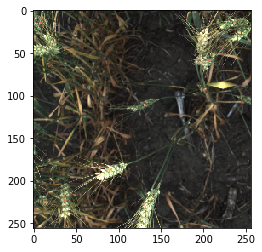

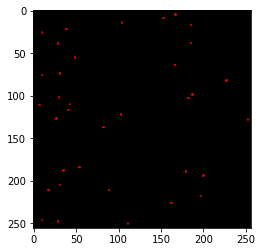

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


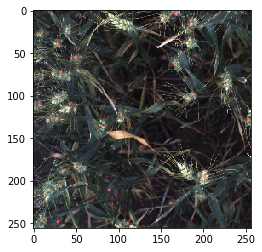

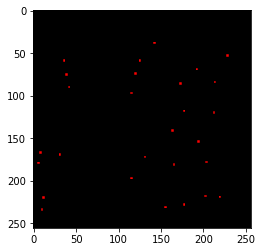

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


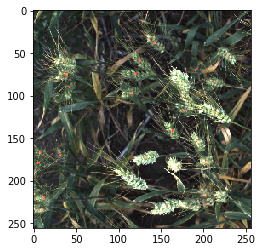

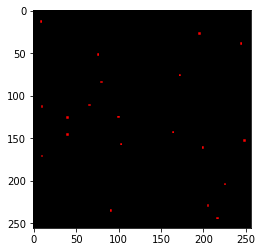

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


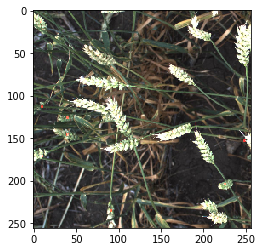

In [9]:
# Test dataset
for i in range(10):
    img, hm, regr = valdataset[i]
    hm = hm.numpy()
    regr = regr.numpy()
    img = img.permute(1,2,0).cpu().numpy()
    hm = np.array([hm, np.zeros_like(hm), np.zeros_like(hm)])
    plt.imshow(hm.transpose([1,2,0]))
    plt.show()
    plt.imshow(img[::4,::4,:] + hm.transpose([1,2,0]))
    plt.show()

In [10]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True, num_workers=num_worker)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True, num_workers=num_worker)

## Import models

In [11]:
from model import CenterNetFPN, centernet

if FPN:
    model = CenterNetFPN(model_name, 4, bifpn=bifpn)
else:
    model = centernet(4, model_name)

model(torch.rand(1,3,512,512))[0].size()

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_WSL-Images_master


torch.Size([1, 1, 128, 128])

In [12]:
model.to(device)

# Optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=lr)

from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True, min_lr=1e-3*1e-5, factor=0.5)

# Import loss

In [13]:
from loss import centerloss
criterion = centerloss

# Train function

In [ ]:
from trainer.trainer import centernet_train, centernet_eval

# Train model

In [ ]:
import gc
from line import LINENotifyBot
line = LINENotifyBot()

os.makedirs("models", exist_ok=True)
epochs=100
logs = []
logs_eval = []
torch.cuda.empty_cache()
gc.collect()

if CONTINUE:
    if modelpath != None:
        model.load_state_dict(torch.load(modelpath))
    else:
        model.load_state_dict(torch.load('./models/{}_{}_{}_{}.pth'.format(watermark, loadepoch, input_size, train_size)))

if TRAIN:
    for epoch in range(epochs):
        print('epochs {}/{} '.format(epoch+1,epochs))
        if WARMUP and epoch==0:
            print("epoch is 0. Lowering LR for the first epoch.")
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr * 0.1
        elif epoch==WARMUPEND:
            print("epoch is {}. ending warmup and increasing LR.".format(WARMUPEND))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                
        for i in range(2):
            centernet_train(model, train_loader, config, criterion, optimizer, logs=logs, epoch=epoch)
        # eval mAP
        centernet_eval(model, val_loader, config, criterion, optimizer, exp_lr_scheduler, line=line, 
                       logs_eval=logs_eval, epoch=epoch, map=True, threshs=0.3, save_stride=2)    
else:
    model.load_state_dict(torch.load('./models/{}_{}_{}_{}.pth'.format(loadwatermark, loadepoch, input_size, train_size)))
    #eval(True)

Preds

In [ ]:
from dataset.dataset import showbox, showgtbox
model = model.eval()
for id in range(10):
    img, hm_gt, regr_gt = valdataset[id]
    with torch.no_grad():
        hm, regr = model(img.to(device).float().unsqueeze(0))
    
    img = img.cpu().numpy().transpose([1,2,0])
    hm = hm.cpu().numpy().squeeze(0).squeeze(0)
    regr = regr.cpu().numpy().squeeze(0) / (input_size/train_size)

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    hmm = np.array([hm, np.zeros_like(hm), np.zeros_like(hm)]).transpose([1,2,0])
    img2 = (img[::4, ::4, :] + (hmm).astype("int"))
    
    sample = showbox(config,img, hm, regr[0:2], regr[2:], 0.4, True)
    
    # show gt
    sample = showgtbox(config, sample, hm_gt, regr_gt[:2], regr_gt[2:], 0.99)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.show()